# Using Python for neuroimaging data

The primary goal of this section is to become familiar with loading, modifying, saving, and visualizing neuroimages in Python. A secondary goal is to develop a conceptual understanding of the data structures involved, to facilitate diagnosing problems in data or analysis pipelines.

To these ends, we'll be exploring two libraries: [nibabel](http://nipy.org/nibabel/) and [nilearn](https://nilearn.github.io/). Each of these projects has excellent documentation. While this should get you started, it is well worth your time to look through these sites.

This notebook only covers nibabel, see the notebook [`image_manipulation_nilearn.ipynb`](image_manipulation_nilearn.ipynb) for more information about nilearn.

# Nibabel

Nibabel is a low-level Python library that gives access to a variety of imaging formats, with a particular focus on providing a common interface to the various **volumetric** formats produced by scanners and used in common neuroimaging toolkits.

 - NIfTI-1
 - NIfTI-2
 - SPM Analyze
 - FreeSurfer .mgh/.mgz files
 - Philips PAR/REC
 - Siemens ECAT
 - DICOM (limited support)

It also supports **surface** file formats

 - GIFTI
 - FreeSurfer surfaces, labels and annotations

**Connectivity**

 - CIFTI-2

**Tractography**

 - TrackViz .trk files

And a number of related formats.

**Note:** Almost all of these can be loaded through the `nibabel.load` interface.

## Setup

In [1]:
# Image settings
from nilearn import plotting
import pylab as plt
%matplotlib inline

import numpy as np
import nibabel as nb

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Loading and inspecting images in `nibabel`

In [2]:
# Load a functional image of subject 01
img = nb.load('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

In [3]:
# Let's look at the header of this file
print(img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (64, 64, 30, 184)
affine: 
[[-3.99471426e+00 -2.04233140e-01  2.29353290e-02  1.30641693e+02]
 [-2.05448717e-01  3.98260689e+00 -3.10890853e-01 -9.74732285e+01]
 [ 6.95819734e-03  3.11659902e-01  3.98780894e+00 -8.06465759e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'?TR:2500.000 TE:50'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4  64  64  30 184   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        4.        4.        3.999975  2.5       1.        1.
  1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_unit

This data-affine-header structure is common to volumetric formats in nibabel, though the details of the header will vary from format to format.

### Access specific parameters

If you're interested in specific parameters, you can access them very easily, as the following examples show.

In [4]:
data = img.get_data()
data.shape

(64, 64, 30, 184)

In [5]:
affine = img.affine
affine

array([[-3.99471426e+00, -2.04233140e-01,  2.29353290e-02,
         1.30641693e+02],
       [-2.05448717e-01,  3.98260689e+00, -3.10890853e-01,
        -9.74732285e+01],
       [ 6.95819734e-03,  3.11659902e-01,  3.98780894e+00,
        -8.06465759e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [6]:
header = img.header['pixdim']
header

array([-1.      ,  4.      ,  4.      ,  3.999975,  2.5     ,  1.      ,
        1.      ,  1.      ], dtype=float32)

Note that in the `'pixdim'` above contains the voxel resolution  (`4., 4., 3.999`), as well as the TR (`2.5`).

#### Aside
Why not just `img.data`? Working with neuroimages can use a lot of memory, so nibabel works hard to be memory efficient. If it can read some data while leaving the rest on disk, it will. `img.get_data()` reflects that it's doing some work behind the scenes.

#### Quirk

 - `img.get_data_dtype()` shows the type of the data on disk
 - `img.get_data().dtype` shows the type of the data that you're working with

These are not always the same, and not being clear on this [has caused problems](https://github.com/nipy/nibabel/issues/490). Further, modifying one does not update the other. This is especially important to keep in mind later when saving files.

In [7]:
print((data.dtype, img.get_data_dtype()))

(dtype('<i2'), dtype('<i2'))


### Data

The data is a simple numpy array. It has a shape, it can be sliced and generally manipulated as you would any array.

(64, 64, 30, 184)


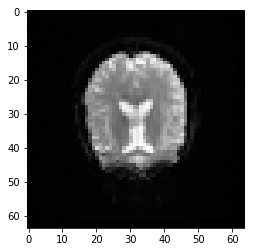

In [8]:
plt.imshow(data[:, :, data.shape[2] // 2, 0].T, cmap='Greys_r')
print(data.shape)

## Exercise 1:

Load the T1 data from subject 1. Plot the image using the same volume indexing as before. Also, print the shape of the data.

(256, 156, 256)


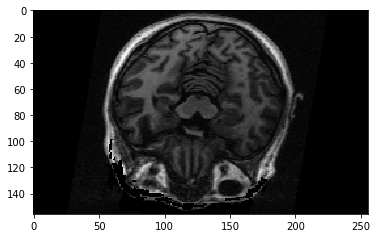

In [9]:
t1 = nb.load('/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
data = t1.get_data()
plt.imshow(data[:, :, data.shape[2] // 2].T, cmap='Greys_r')
print(data.shape)

In [10]:
# Work on solution here

### `img.orthoview()`

Nibabel has its own viewer, which can be accessed through **`img.orthoview()`**. This viewer scales voxels to reflect their size, and labels orientations.

**Warning:** `img.orthoview()` may not work properly on OS X.

#### Sidenote to plotting with `orthoview()`
As with other figures, f you initiated `matplotlib` with `%matplotlib inline`, the output figure will be static. If you use `orthoview()` in a normal IPython console, it will create an interactive window, and you can click to select different slices, similar to `mricron`. To get a similar experience in a jupyter notebook, use `%matplotlib notebook`. But don't forget to close figures afterward again or use `%matplotlib inline` again, otherwise, you cannot plot any other figures.

<IPython.core.display.Javascript object>


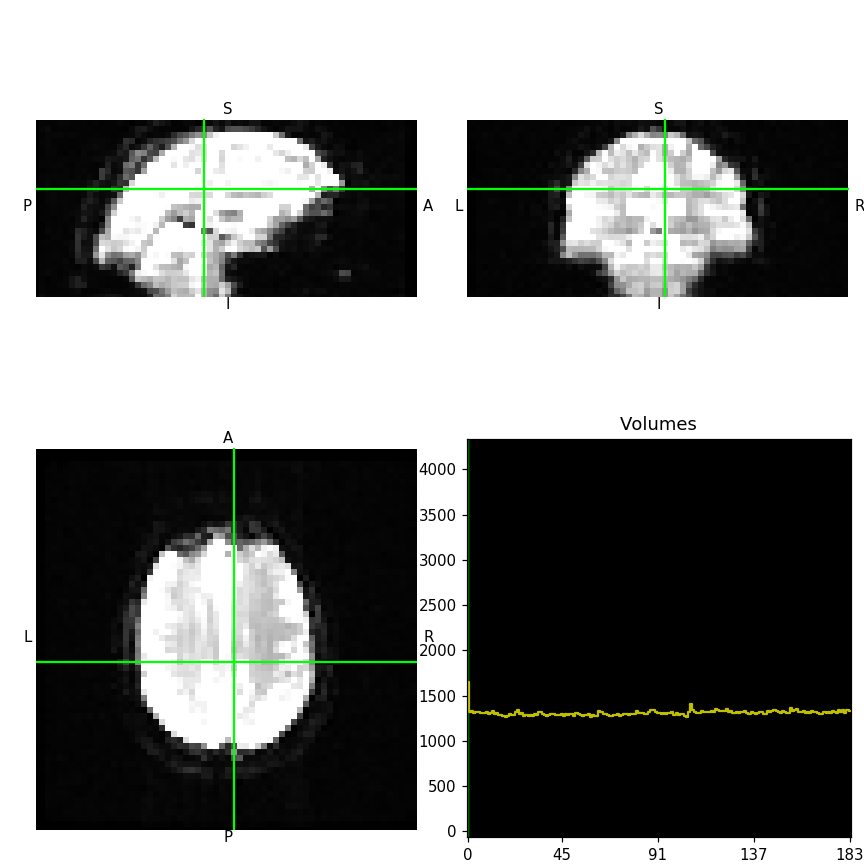

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nibabel/viewers.py:416: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  vdata = self._data[idx].ravel()


<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz (64, 64, 30, 184)>

In [33]:
%matplotlib notebook
img.orthoview()

### Affine

The affine is a 4 x 4 numpy array. This describes the transformation from the voxel space (indices [i, j, k]) to the reference space (distance in mm (x, y, z)).

It can be used, for instance, to discover the voxel that contains the origin of the image:

In [12]:
x, y, z, _ = np.linalg.pinv(affine).dot(np.array([0, 0, 0, 1])).astype(int)

print("Affine:")
print(affine)
print
print("Center: ({:d}, {:d}, {:d})".format(x, y, z))

Affine:
[[-3.99471426e+00 -2.04233140e-01  2.29353290e-02  1.30641693e+02]
 [-2.05448717e-01  3.98260689e+00 -3.10890853e-01 -9.74732285e+01]
 [ 6.95819734e-03  3.11659902e-01  3.98780894e+00 -8.06465759e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Center: (31, 27, 18)


The affine also encodes the axis orientation and voxel sizes:

In [13]:
nb.aff2axcodes(affine)

('L', 'A', 'S')

In [14]:
nb.affines.voxel_sizes(affine)

array([3.99999995, 4.00000009, 3.99997491])

In [15]:
nb.aff2axcodes(affine)

('L', 'A', 'S')

In [16]:
nb.affines.voxel_sizes(affine)

array([3.99999995, 4.00000009, 3.99997491])

<IPython.core.display.Javascript object>


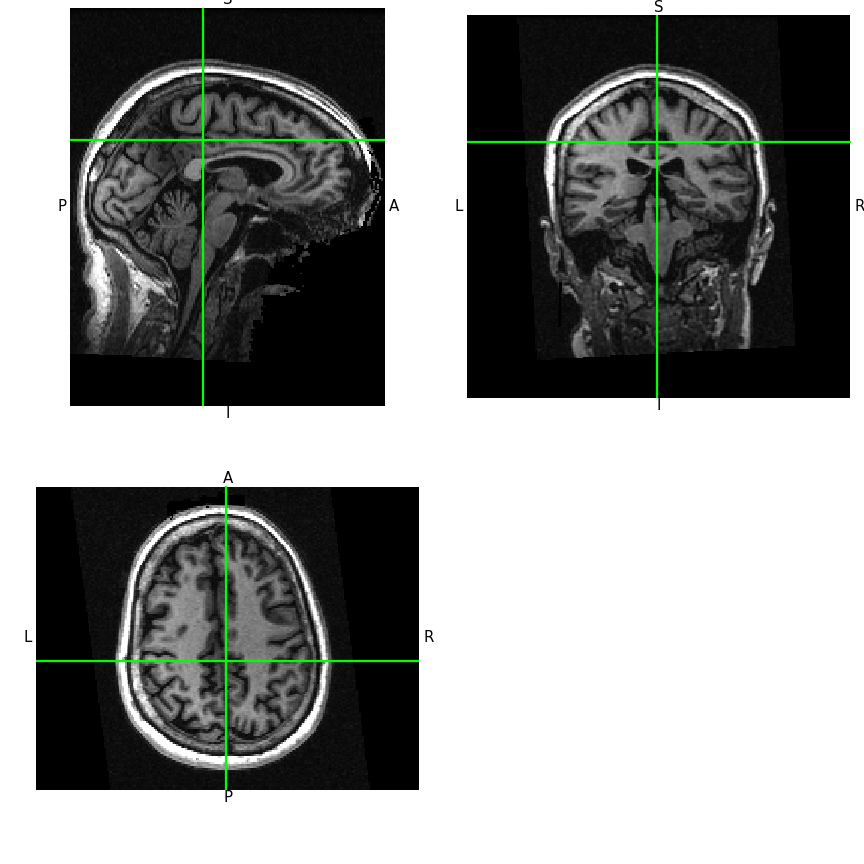

<OrthoSlicer3D: /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz (256, 156, 256)>

In [34]:
t1.orthoview()

### Header

The header is a nibabel structure that stores all of the metadata of the image. You can query it directly, if necessary:

In [18]:
t1.header['descrip']

array(b'FSL5.0', dtype='|S80')

But it also provides interfaces for the more common information, such as `get_zooms`, `get_xyzt_units`, `get_qform`, `get_sform`).

In [19]:
t1.header.get_zooms()

(1.0, 1.2993759, 1.0)

In [20]:
t1.header.get_xyzt_units()

('mm', 'sec')

In [21]:
t1.header.get_qform()

array([[ 9.99131938e-01, -5.16292391e-02,  1.25136054e-02,
        -1.25263863e+02],
       [ 4.07721521e-02,  1.29202043e+00, -9.81179047e-02,
        -7.31330109e+01],
       [-8.54416425e-03,  1.28044319e-01,  9.95096119e-01,
        -1.77554291e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [22]:
t1.header.get_sform()

array([[ 9.99131918e-01, -5.16291820e-02,  1.25127016e-02,
        -1.25263863e+02],
       [ 4.07721959e-02,  1.29202044e+00, -9.81179178e-02,
        -7.31330109e+01],
       [-8.54506902e-03,  1.28044292e-01,  9.95096147e-01,
        -1.77554291e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

Normally, we're not particularly interested in the header or the affine. But it's important to know they're there. And especially, to remember to copy them when making new images, so that derivatives stay aligned with the original image.

## `nib-ls`

Nibabel comes packaged with a command-line tool to print common metadata about any (volumetric) neuroimaging format nibabel supports. By default, it shows (on-disk) data type, dimensions and voxel sizes. 

In [23]:
!nib-ls /data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz int16 [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50   sform



We can also inspect header fields by name, for instance, `descrip`:

In [24]:
!nib-ls -H descrip /data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz float32 [256, 156, 256] 1.00x1.30x1.00   b'FSL5.0' sform



## Creating and saving images

Suppose we want to save space by rescaling our image to a smaller datatype, such as an unsigned byte. To do this, we first need to take the data, change its datatype and save this new data in a new NIfTI image with the same header and affine as the original image.

In [25]:
# First, we need to load the image and get the data
img = nb.load('/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
data = img.get_data()

In [26]:
# Now we force the values to be between 0 and 255
# and change the datatype to unsigned 8-bit
rescaled = ((data - data.min()) * 255. / (data.max() - data.min())).astype(np.uint8)

In [27]:
# Now we can save the changed data into a new NIfTI file
new_img = nb.Nifti1Image(rescaled, affine=img.affine, header=img.header)
nb.save(new_img, '/tmp/rescaled_image.nii.gz')

Let's look at the datatypes of the data array, as well as of the nifti image:

In [28]:
print((new_img.get_data().dtype, new_img.get_data_dtype()))

(dtype('uint8'), dtype('<i2'))


That's not optimal. Our data array has the correct type, but the on-disk format is determined by the header, so saving it with `img.header` will not do what we want. Also, let's take a look at the size of the original and new file.

In [29]:
orig_filename = img.get_filename()
!du -hL /tmp/rescaled_image.nii.gz $orig_filename

12M	/tmp/rescaled_image.nii.gz
24M	/data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz


So, let's correct the header issue with the `set_data_dtype()` function:

In [30]:
img.set_data_dtype(np.uint8)

In [31]:
# Save image again
new_img = nb.Nifti1Image(rescaled, affine=img.affine, header=img.header)
nb.save(new_img, '/tmp/rescaled_image.nii.gz')
print((new_img.get_data().dtype, new_img.get_data_dtype()))

(dtype('uint8'), dtype('uint8'))


Perfect! Now the data types are correct. And if we look at the size of the image we even see that it got a bit smaller.

In [32]:
!du -hL /tmp/rescaled_image.nii.gz

9.5M	/tmp/rescaled_image.nii.gz


# Conclusions

In the two notebooks about `nibabel` and `nilearn`, we've explored loading, saving and visualizing neuroimages, as well as how both packages can make some more sophisticated manipulations easy. At this point, you should be able to inspect and plot most images you encounter, as well as make modifications while preserving the alignment.